<img src="https://farm66.staticflickr.com/65535/49055715328_092031af74_o.png"  width="150" />

### CBPF - Centro Brasileiro de Pesquisas Físicas

# Projeto final do curso de Análise de big data e Astroinformática

### João Paulo Correia de França
### contato: joao.contato505@gmail.com


### Professor: Clécio R. de Bom

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import *
import os, fnmatch
from PIL import Image

%matplotlib inline

In [2]:
# deep learning results
deep_results = pd.read_csv('./results_catalog.txt')
deep_results.head()

,id,Einstein_Radius_actual,Einstein_Radius_Inception,Einstein_Radius_Sequential,Einstein_Radius_ResNet,Einstein_Radius_ResNetXt,Sigma_V_actual,Sigma_V_Inception,Sigma_V_Sequential,Sigma_V_ResNet,...,RedShift_Lens_ZL_actual,RedShift_Lens_ZL_Inception,RedShift_Lens_ZL_Sequential,RedShift_Lens_ZL_ResNet,RedShift_Lens_ZL_ResNetXt,Redshift_Source_ZS_actual,Redshift_Source_ZS_Inception,Redshift_Source_ZS_Sequential,Redshift_Source_ZS_ResNet,Redshift_Source_ZS_ResNetXt
0,0,1.716,1.54308,1.63556,1.60419,1.87451,279.904,291.215,292.208,293.536,...,0.378,0.398122,0.435342,0.377477,0.419813,2.776,2.564690,2.03192,2.24000,1.929650
1,1,1.433,1.78372,1.58602,1.58634,1.48138,346.114,332.267,340.017,335.997,...,0.834,0.805235,0.794858,0.718788,0.767183,1.827,2.324070,2.40681,2.29777,2.656040
2,3,1.325,1.34623,1.53789,1.03845,1.41403,260.482,257.948,260.697,245.173,...,0.381,0.324546,0.370329,0.317963,0.353732,1.633,1.537820,1.92407,2.36051,1.725220
3,4,0.993,1.17223,1.11795,1.07006,1.29498,269.369,258.188,248.708,242.475,...,0.258,0.242271,0.217607,0.248105,0.235744,0.527,0.660075,1.29210,1.00098,0.764566
4,5,1.072,1.28036,1.18530,1.22772,1.06243,224.926,255.804,233.241,245.332,...,0.350,0.379734,0.380019,0.427648,0.407995,2.007,1.102130,1.57857,1.56287,1.636210


In [3]:
# cutting data
deep_results = deep_results[deep_results["Einstein_Radius_actual"]<2.25]

In [4]:
# get metrics, such as mean bias, median bias and sigma68
def get_metrics(true,predicted):
    """
    def function which give metrics on data
    true: list/array
        true values
    predicted: list/array
        predicted values
    """
    # delta einstein angle
    deltatheta=true-predicted
    # bias over mean
    mean_bias=np.mean(deltatheta)
    # sigma 16 and 84 percentiles
    p16=np.percentile(deltatheta,15.85)
    p84=np.percentile(deltatheta,84.05)
    # sigma 68 
    sigma68=0.5*(p84-p16)
    # bias over median
    median_bias=np.percentile(deltatheta,50)
    return mean_bias,median_bias,sigma68

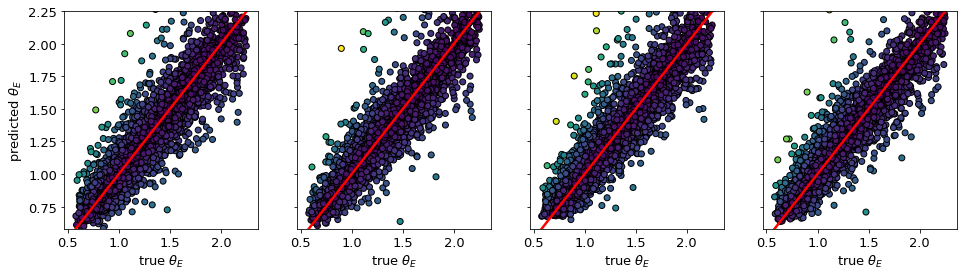

In [5]:
# results of deep learning analysis predicted x true analysis
types = ['Inception', 'Sequential', 'ResNet', 'ResNetXt']

plt.rcParams.update({"font.size": 13})

fig, ax = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
    
for i in range(0, len(types)):
    ax[i].scatter(deep_results['Einstein_Radius_actual'], deep_results['Einstein_Radius_'+types[i]], c=np.abs(deep_results['Einstein_Radius_'+types[i]]-deep_results['Einstein_Radius_actual'])/deep_results['Einstein_Radius_actual'], ec='k')
    ax[i].plot(np.linspace(min(deep_results['Einstein_Radius_actual']), max(deep_results['Einstein_Radius_actual'])), np.linspace(min(deep_results['Einstein_Radius_actual']), max(deep_results['Einstein_Radius_actual'])), 'r', lw=2.5)
    ax[i].set_ylim(min(deep_results['Einstein_Radius_actual']), 2.25);
    ax[i].set_xlabel('true $θ_E$')

    if i == 0:
        ax[i].set_ylabel('predicted $θ_E$')

In [6]:
# metrics output
for i in range(0, len(types)):
    mean_bias, median_bias, sigma68=get_metrics(deep_results['Einstein_Radius_actual'], deep_results['Einstein_Radius_'+types[i]])
    print('====================='+types[i]+'=====================')
    print('σ68: '+str(round(sigma68,3)), ', Mean Bias: '+str(round(mean_bias,3)), ', Median Bias: '+str(round(median_bias,3)))

=====================Inception=====================
σ68: 0.129 , Mean Bias: -0.002 , Median Bias: -0.001
=====================Sequential=====================
σ68: 0.114 , Mean Bias: -0.003 , Median Bias: 0.002
=====================ResNet=====================
σ68: 0.13 , Mean Bias: -0.004 , Median Bias: 0.003
=====================ResNetXt=====================
σ68: 0.112 , Mean Bias: -0.006 , Median Bias: -0.003


## Outlier detection on bayesian analysis

In [7]:
def find(pattern, path):
    """
    def function to get specific files on a folder

    pattern: str
        file extension
    path: str
        path of the file
    """
    result = []
    for root, dirs, files in os.walk(path):
        for name in files:
            if fnmatch.fnmatch(name, pattern):
                result.append(os.path.join(root, name))
    return result

In [8]:
# duplicated output path, picking-up only pair
fit_images = find('subplot_fit_imaging.png', '/home/joao/Documents/GitHub/BigDataProject/output/')
del fit_images[1::2]

In [9]:
print('Total inverse modeling files on path:', len(fit_images))

Total inverse modeling files on path: 30


In [10]:
# visual way to detect outliers, option list for widgets
optionslist = []
for i in range(0,len(fit_images)):
    optionslist.append(i)

In [11]:
def update_graph(i):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    print(fit_images[i][50:-76])
    fig, ax = plt.subplots(1, 1, figsize=(16, 16), sharex=True, sharey=True)
    img=np.array(Image.open(fit_images[i]))
    ax.imshow(img)
    ax.set_xticks([])
    ax.set_yticks([])
    
i = widgets.Dropdown(options=optionslist, value=15, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', index=15, options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, …

In [12]:
# outliers detected
outliers = [343, 330, 860, 474, 276, 87, 769, 805, 1215, 121, 871, 1095, 955, 1082, 1337]
print('Number of detected outliers: ', len(outliers))

Number of detected outliers:  15


In [13]:
# Catalog simulation parameters (true values)
lenses_DESc = pd.read_csv('./lenses_DESc.txt',
                          sep=' ',
                          comment='#',
                          names=['id', 'zl', 'zs', 'b', 'sig_v', 'ql', 'rl', 'lens_g', 'lens_r', 'lens_i', 'xs', 'ys', 'qs', 'ps', 'rs', 'source_g', 'source_r', 'source_i', 'mu_s', 'g_band_coadd_seeing', 'g_band_coadd_signal_to_noise', 'r_band_coadd_seeing', 'r_band_coadd_signal_to_noise', 'i_band_coadd_seeing'])
lenses_DESc.head()

,id,zl,zs,b,sig_v,ql,rl,lens_g,lens_r,lens_i,...,rs,source_g,source_r,source_i,mu_s,g_band_coadd_seeing,g_band_coadd_signal_to_noise,r_band_coadd_seeing,r_band_coadd_signal_to_noise,i_band_coadd_seeing
0,0,0.320,1.784,1.497,265.112,0.771,1.330,19.961,18.086,17.442,...,131.188,0.290,6.413,1.352,37.000,1.352,19.368,1.352,11.432,32.021
1,1,0.402,1.790,1.372,264.665,0.811,0.819,20.778,18.833,18.103,...,35.232,0.408,4.585,1.352,22.528,1.352,11.003,1.352,9.419,19.750
2,3,0.569,1.285,1.361,318.578,0.671,0.853,21.374,19.530,18.255,...,113.910,0.290,8.931,1.352,32.892,1.352,22.761,1.352,16.575,28.284
3,4,0.189,3.385,1.686,257.082,0.709,2.291,18.166,16.757,16.249,...,125.445,0.321,7.212,1.352,23.054,1.352,15.983,1.352,9.900,17.660
4,5,0.568,1.057,0.658,242.661,0.768,0.409,22.679,20.836,19.562,...,53.932,0.008,156.589,1.352,0.002,1.352,21.890,1.352,25.334,0.000


In [14]:
# picking up results obtained after an outlier detection, here we compare with nominal values
theta_einstein = []
theta_einstein_chains = []
index = []
for i in range(0, len(fit_images)):
    if int(fit_images[i][50:-76]) not in outliers:
        # getting the system index
        idx=int(fit_images[i][50:-76])
        index.append(idx)
        # getting model results, here we have used pickle to recover all the model
        model_results_path=find('samples.pickle', '/home/joao/Documents/GitHub/BigDataProject/output/'+str(idx))[0]
        result = pd.read_pickle(model_results_path)
        # MCMC chain
        chain = pd.DataFrame(np.array(result.results["samples"]), columns=result.names, dtype=float)
        burnin = int(len(chain)*0.7) # burnin of 10%
        # getting the percentiles of 1 sigma
        theta_value_inf, theta_value, theta_value_sup = np.percentile(chain['galaxies_lens_mass_einstein_radius'][burnin:], [15.85, 50., 84.05])
        # passing through a list from dictionary
        theta_einstein_chains.append(np.array(chain['galaxies_lens_mass_einstein_radius']))
        theta_einstein.append({'inf':theta_value_inf, 'mean':theta_value, 'sup':theta_value_sup})

2021-11-11 17:46:38,967 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autofit/config


2021-11-11 17:46:39,651 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autoarray/config
2021-11-11 17:46:39,735 - autoconf.conf - WARNING - Pushing new config with path /home/joao/.local/lib/python3.8/site-packages/autogalaxy/config


In [ ]:
# variation over the real value

In [36]:
disc = []
for i in range(0, len(theta_einstein)):
    disc.append(theta_einstein[i]['mean']- float(lenses_DESc[lenses_DESc['id']==index[i]]['b']))

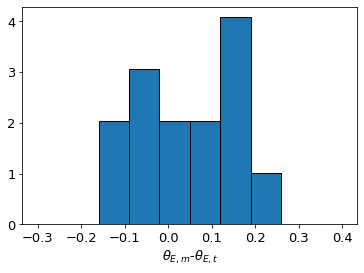

In [56]:
plt.rcParams.update({"font.size": 13})
plt.hist(disc, range=(-0.3, 0.4), ec='k', bins=10, density=True)
plt.xlabel('$θ_{E,m}$-$θ_{E,t}$');

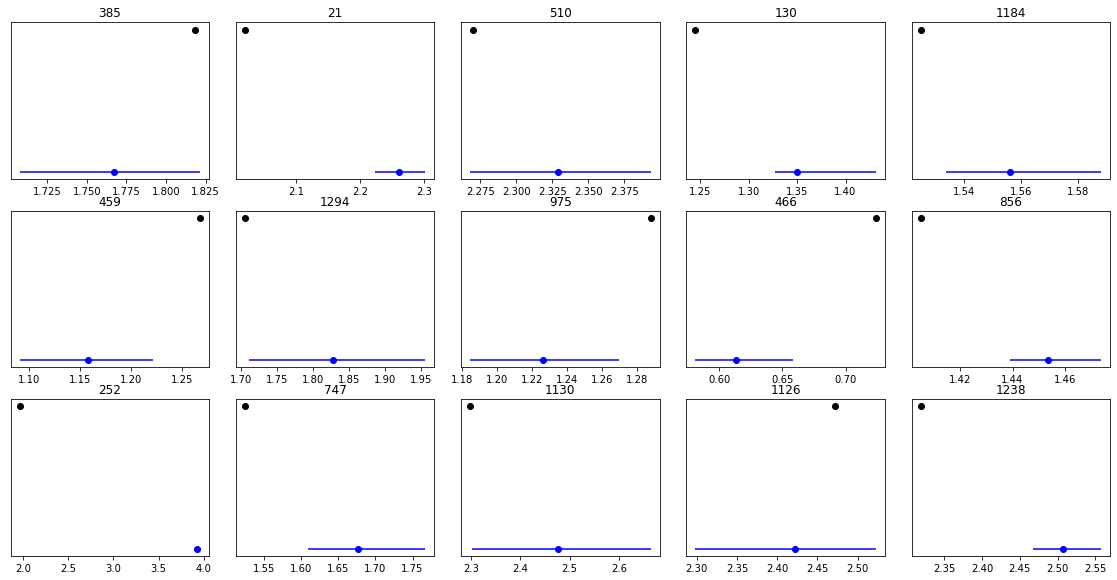

In [18]:
# graph to compare nominal values to predicted ones in 1 sigma
plt.rcParams.update({"font.size": 10})

# rows and columns
rows = 3
columns = 5

theta_einstein_reshaped = np.array(theta_einstein).reshape(rows, columns)
index_reshaped = np.array(index).reshape(rows, columns)

fig, ax = plt.subplots(rows, columns, figsize=(16, 8), sharey=True)
fig.tight_layout() 
for i in range(0, rows):
    for j in range(0, columns):
        ax[i][j].errorbar(theta_einstein_reshaped[i][j]['mean'], 0, xerr=[[theta_einstein_reshaped[i][j]['mean']-theta_einstein_reshaped[i][j]['inf']], [theta_einstein_reshaped[i][j]['sup']-theta_einstein_reshaped[i][j]['mean']]], fmt="o", c="b")
        #print(float(lenses_DESc[lenses_DESc['id']==index[i]]['b']))
        ax[i][j].plot(float(lenses_DESc[lenses_DESc['id']==index_reshaped[i][j]]['b']), 1, 'ko')
        ax[i][j].set_yticks([])
        ax[i][j].set_title(str(index_reshaped[i][j]))

In [19]:
# widget image options
image_model_optionlist = []
for i in range(0, len(index)):
        image_model_optionlist.append(i)

In [24]:
# only the good ones
fit_images_ok = []
for i in range(0, len(fit_images)):
    if int(fit_images[i][50:-76]) in index:
        fit_images_ok.append(fit_images[i])

In [53]:
def update_graph(i):
    """
    def function to update our visual graph
    i: int
        option, system
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    fig.suptitle('$θ_{E, t}$:  '+str(round(float(lenses_DESc[lenses_DESc['id']==index[i]]['b']), 2))+'   $θ_{E, m}$: '+str(round(theta_einstein[i]['mean'], 2)) + ' $\pm$ (' +str(round(theta_einstein[i]['mean']-theta_einstein[i]['inf'], 2))+ ', '+str(round(theta_einstein[i]['sup']-theta_einstein[i]['mean'], 2))+')', fontsize=20)
    
    img=np.array(Image.open(fit_images_ok[i]))
    
    ax[0].imshow(img)
    ax[0].set_title('Original Image')
    ax[0].set_xlim(160, 440)
    ax[0].set_ylim(390, 120)
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    ax[0].spines['top'].set_visible(False)
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['bottom'].set_visible(False)
    ax[0].spines['left'].set_visible(False)
    
    ax[1].imshow(img)
    ax[1].set_title('Model Image')
    ax[1].set_xlim(870, 1150)
    ax[1].set_ylim(390, 120)
    ax[1].set_xticks([])
    ax[1].set_yticks([])
    ax[1].spines['top'].set_visible(False)
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['bottom'].set_visible(False)
    ax[1].spines['left'].set_visible(False)

    
i = widgets.Dropdown(options=image_model_optionlist, value=0, description='Component:', disabled=False)
widgets.interactive(update_graph,i = i)

interactive(children=(Dropdown(description='Component:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13…